In [1]:
import torch
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

path_hr

PosixPath('/home/luan/.fastai/data/oxford-iiit-pet/images')

## Crappified data

In [4]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [5]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

In [6]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256

## Pre-trained generator

In [16]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [4]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [17]:
data_gen = get_data(bs,size)

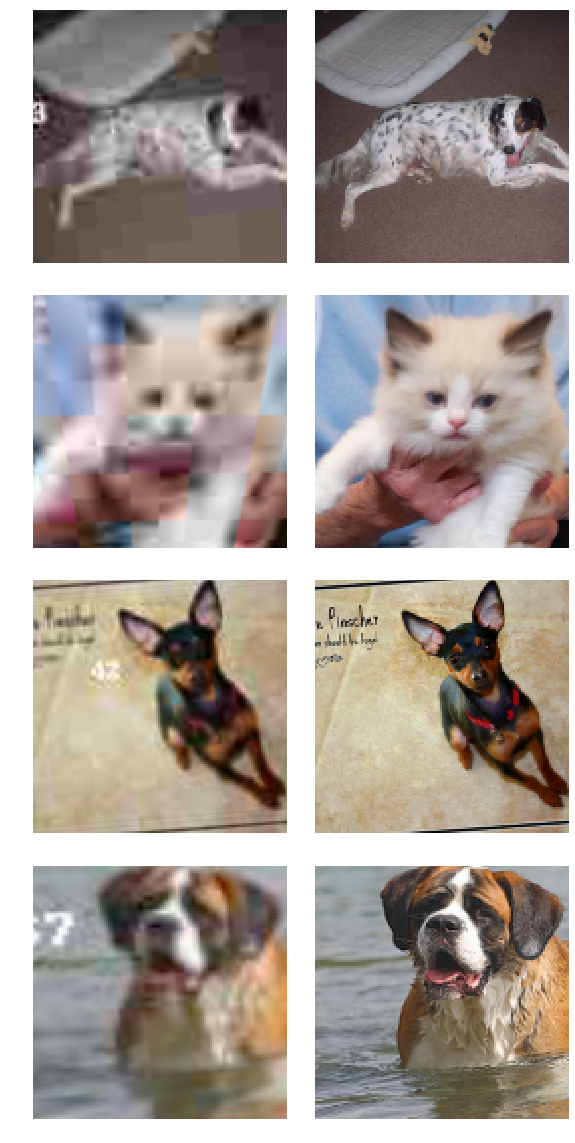

In [10]:
data_gen.show_batch(4)

In [11]:
wd = 1e-3  # ???? 
y_range = (-3.,3.) # ????
loss_gen = MSELossFlat()

In [5]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [13]:
learn_gen = create_gen_learner()

In [14]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [15]:
learn_gen.unfreeze()

In [16]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

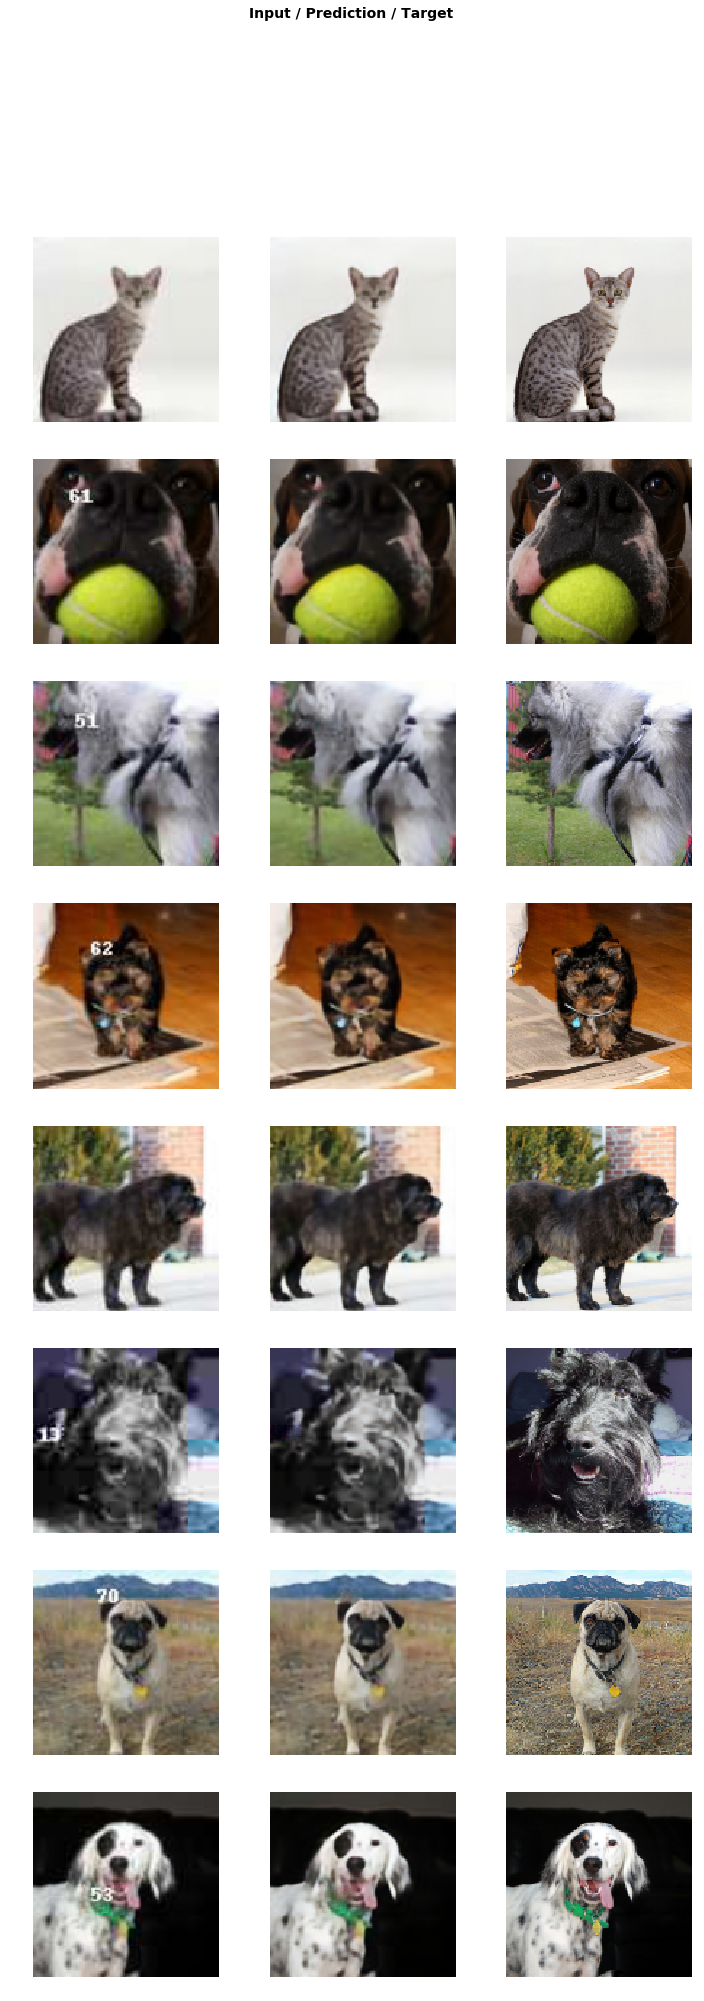

In [17]:
learn_gen.show_results(rows=8)

In [18]:
learn_gen.save('gen-pre2')

## Save Generated Images

In [ ]:
learn_gen.load('gen-pre2')

In [19]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [20]:
path_gen.mkdir(exist_ok=True)

In [21]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [22]:
save_preds(data_gen.fix_dl)

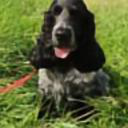

In [23]:
PIL.Image.open(path_gen.ls()[12])

## Train critic

In [24]:
learn_gen=None
gc.collect()

20

In [6]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [26]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

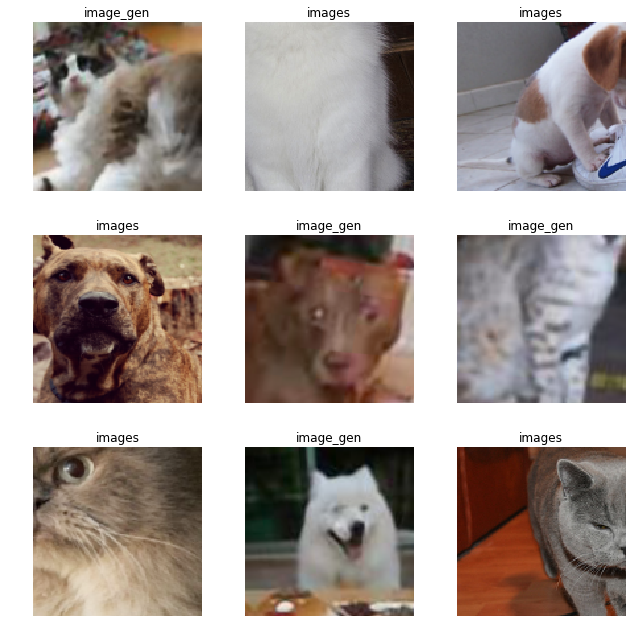

In [27]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [12]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss()) # ?? AdaptiveLoss? b

In [7]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [30]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [31]:
learn_critic.fit_one_cycle(6, 1e-3)

In [43]:
learn_critic.save('critic-pre2')

# GAN

In [8]:
learn_crit=None
learn_gen=None
gc.collect()

7

In [9]:
bs,size=32, 128
wd = 1e-3  # ???? 
y_range = (-3.,3.) # ????
loss_gen = MSELossFlat()
#bs,size = 24,160

In [10]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [13]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [18]:
learn_gen = create_gen_learner().load('gen-pre2')

In [19]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [26]:
lr = 1e-4

In [27]:
learn.fit(40,lr)

In [28]:
learn.save('gan-1c')

In [21]:
learn.load('gan-1c', purge=False)

GANLearner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/luan/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/luan/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): MaxPool

In [22]:
learn.data=get_data(12,192) # get bigger picture :D

In [23]:
lr = 1e-4
learn.fit(10,lr/2)

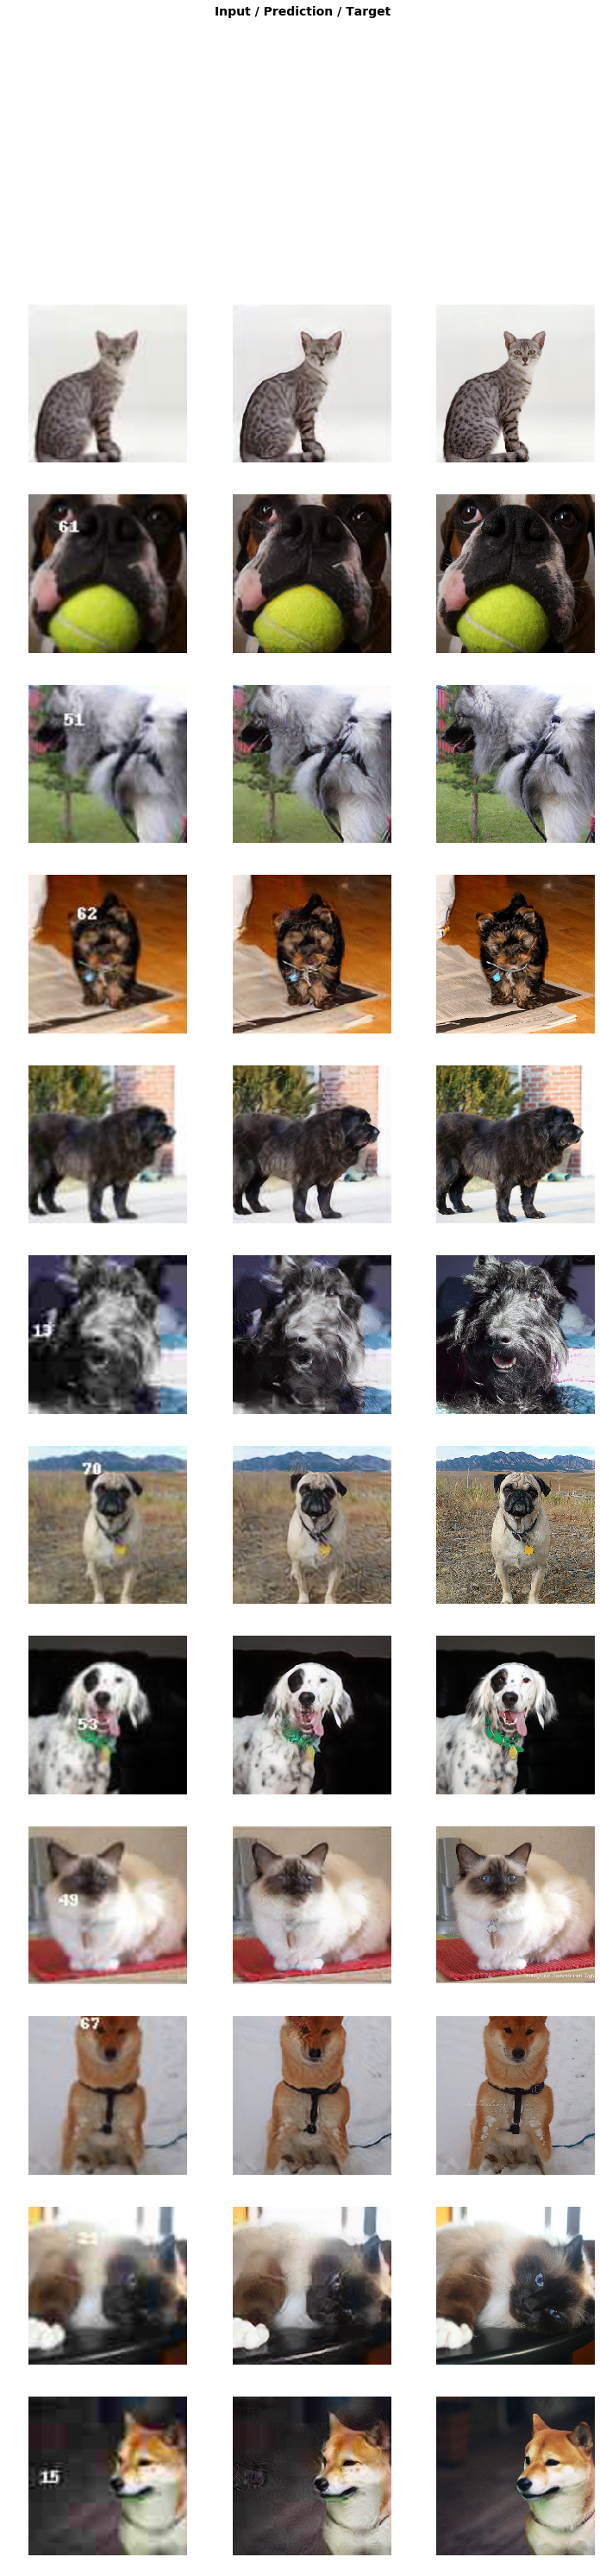

In [24]:
learn.show_results(rows=16)

In [25]:
learn.save('gan-2c')